In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import argparse
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import seaborn as sns
from tqdm import tqdm
import datetime
import calendar


def report_metrics(y_true, y_pred):
    '''
    Output metrics of predictions vs truth
    '''
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"MSE:  {mse}")
    print(f"MAE:  {mae}")
    print(f"MAPE: {mape}")
    print(f"R^2:  {r2}")
    return mse, mae, r2


def month_str(time):
    '''
    Returns two strings representing the first and last day of time's month
    '''
    if time.month < 10:
        month_str = "0" + str(time.month)
    else:
        month_str = str(time.month)

    start_str = str(time.year) + "-" + month_str + "-01 00:14:00"
    last_day = calendar.monthrange(time.year, time.month)[1]
    end_str = str(time.year) + "-" + month_str + "-" + str(last_day) + " 23:59:00"
    return start_str, end_str


def year_str(time):
    '''
    Returns two strings representing the first and last day of time's year
    '''
    start_time = str(time.year) + "-01-01 00:14:00"
    end_time = str(time.year) + "-12-31 23:59:00"
    return start_time, end_time



class Normalised_Flow_Model:
    def __init__(self, train_report):
        self.time_range = pd.date_range("2019-03-19 00:14:00", "2022-04-08 23:59:00", freq="15min")
        # Don't include out of sync time values
        train_report_in_range = train_report[train_report.timestamp.isin(self.time_range)]
        self.predictions = train_report_in_range.groupby('timestamp')['total_volume_normalised'].median().to_frame().reset_index()
        self.true_mu = self.predictions.total_volume_normalised.sum() / len(self.time_range)
        self.empty_times = []
        
    def check_empties(self):
        for t in tqdm(self.time_range):
            if len( self.predictions[self.predictions.timestamp==t] ) <1:
                self.empty_times.append(t)
                
        print(f"{len(self.empty_times)} of {len(self.time_range)} time values are empty, {len(self.empty_times)/len(self.time_range) *100} %")
        
    def N(self,t):
        result = self.predictions[self.predictions.timestamp == t]
        if len(result) == 1:
            N_t = result.total_volume_normalised.to_numpy().item()
        else:
            N_t = 0
        return N_t
    
    
    def mean_N(self, date_range):
        '''
        Returns the average normalised volume over date_range
        '''
        N_t_in_date_range = self.predictions[self.predictions.timestamp.isin(date_range)]
        mean_N_t = N_t_in_date_range.total_volume_normalised.sum()/len(date_range)
        return mean_N_t
    
    def mean_N_year(self, time):
        '''
        Returns a prediction for the average normalised volume over a year
        '''
        # Get two strings representing the start and end of the year
        start_time, end_time = year_str(time)
        date_range = pd.date_range(start_time, end_time, freq="15min")
        
        mean_N_t = self.mean_N(date_range)
        return mean_N_t
        
        
    def mean_N_month(self, time):
        '''
        Returns a prediction for the average normalised volume over a month
        '''
        # Get two strings representing the start and end of the month
        start_time, end_time = month_str(time)
        # Use these strings to create a daterange
        date_range = pd.date_range(start_time, end_time, freq="15min")
        
        mean_N_t = self.mean_N(date_range)
        return mean_N_t

In [2]:
# Import Traffic count predictions
traffic_predictions = pd.read_feather('predictions/traffic-counts/pred_traffic_counts_yolov5')
# Import the traffic data to produce median models
clean_birmingham_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_birmingham_report_df_norm')
clean_manchester_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_manchester_report_df_norm')
clean_cambridge_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_cambridge_report_df_norm')
clean_thorpe_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_thorpe_report_df_norm')
clean_epping_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_epping_report_df_norm')
clean_bristol_report_df_norm = pd.read_feather('high_quality_traffic_reports/clean_bristol_report_df_norm')
print('\nImported Reports\n')


Imported Reports



In [84]:
def model_aadt(train_report, test_report, time):
    AADT_preds = []
    AADTs = []
    a = Normalised_Flow_Model(train_report)
    start_str, end_str = year_str(time)
    date_range = pd.date_range(start_str, end_str, freq="15min")
    for site in tqdm(test_report.site_id.unique()):
        test_report_site = test_report[(test_report.site_id == site)]
        AADT = test_report_site[test_report_site.timestamp.isin(date_range)].total_volume.sum()/len(date_range)
        X_t = test_report_site[test_report_site.timestamp == time].total_volume.to_numpy()
        AADT_pred = X_t/a.N(time) * a.mean_N_year(time)
        # print(f"AADT {AADT}, X_t {X_t}, N(t) {a.N(time)}, N_(2021): {a.mean_N_year(2021)}, AADT_pred {AADT_pred}")
        AADTs.append(AADT)
        AADT_preds.append(AADT_pred.item())

    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=AADTs, y=AADT_preds, ax=ax)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    plt.plot(lims, lims, 'k-', alpha=0.5)

    plt.show()

    results = report_metrics(AADTs, AADT_preds)
    return results, a

In [10]:
def model_amdt(train_report, test_report, time):
    AMDT_preds = []
    AMDTs = []
    a = Normalised_Flow_Model(train_report)
    start_str, end_str = month_str(time)
    date_range = pd.date_range(start_str, end_str, freq="15min")
    for site in tqdm(test_report[test_report.timestamp == time].site_id.unique()):
        test_report_site = test_report[(test_report.site_id == site)]
        AMDT = test_report_site[test_report_site.timestamp.isin(date_range)].total_volume.sum()/len(date_range)
        X_t = test_report_site[test_report_site.timestamp == time].total_volume.to_numpy()
        AMDT_pred = X_t/a.N(time) * a.mean_N_month(time)
        AMDTs.append(AMDT)
        AMDT_preds.append(AMDT_pred.item())

    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=AMDTs, y=AMDT_preds, ax=ax)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    plt.plot(lims, lims, 'k-', alpha=0.5)

    plt.show()

    results = report_metrics(AMDTs, AMDT_preds)
    return results, a

In [5]:
reports = {"birmingham": clean_birmingham_report_df_norm,
          "manchester" : clean_manchester_report_df_norm,
          "cambridge" : clean_cambridge_report_df_norm,
          "thorpe" : clean_thorpe_report_df_norm,
          "epping" : clean_epping_report_df_norm,
          "bristol" : clean_bristol_report_df_norm }

In [6]:
def get_reports(test_loc):
    test_report = pd.concat([v for k,v in reports.items() if k == test_loc])
    train_report = pd.concat([v for k,v in reports.items() if k != test_loc])
    return train_report, test_report

### AADT

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:02<00:00,  9.14it/s]


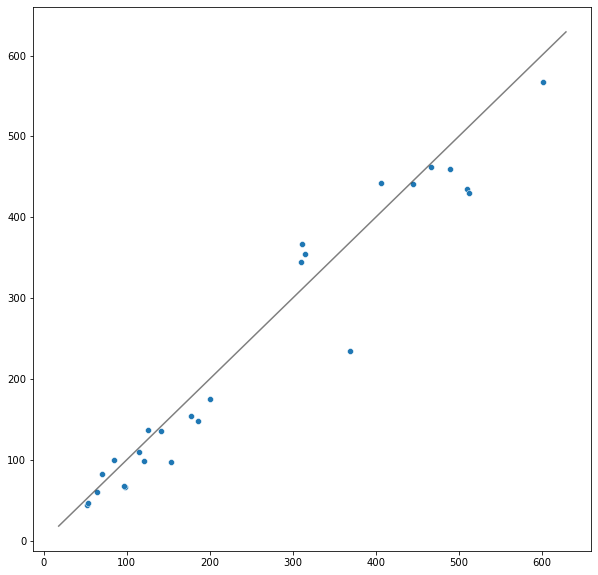

MSE:  1862.837915061432
MAE:  31.632224089785645
MAPE: 0.14652145757433047
R^2:  0.9358386080048329


In [7]:
train_report, test_report = get_reports("birmingham")
time = datetime.datetime(2021,6,15,11,14)
results, model = model_aadt(train_report, test_report, time)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 23.86it/s]


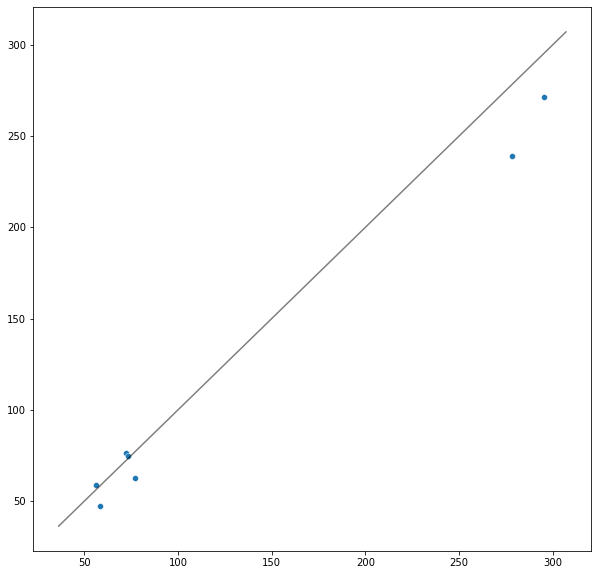

MSE:  350.6907116965698
MAE:  13.813202945553545
MAPE: 0.10308885534205134
R^2:  0.9644839168758337


In [8]:
train_report, test_report = get_reports("cambridge")
time = datetime.datetime(2021,11,2,11,29)
results, model = model_aadt(train_report, test_report, time)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.46it/s]


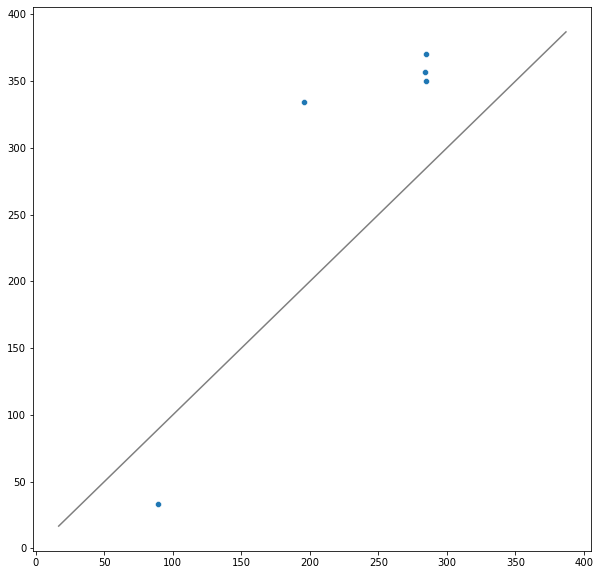

MSE:  7827.051991020215
MAE:  83.45455748060456
MAPE: 0.42344156616363415
R^2:  -0.30656878014790667


In [9]:
train_report, test_report = get_reports("bristol")
time = datetime.datetime(2020,8,8,11,14)
results, model = model_aadt(train_report, test_report, time)

### AMDT

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.15it/s]


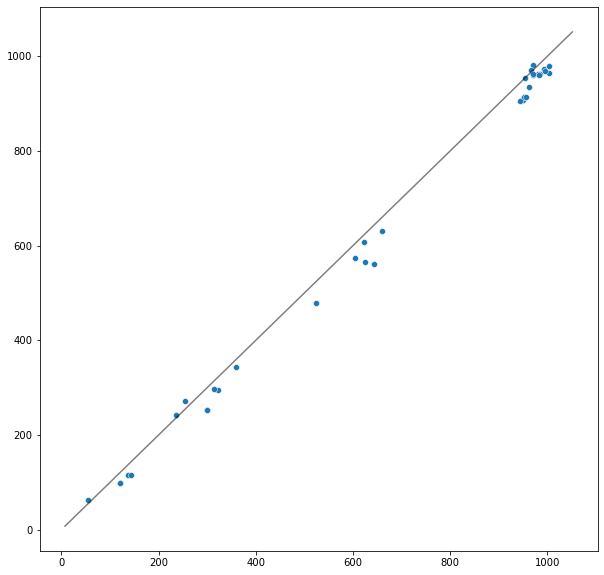

MSE:  983.7198036980911
MAE:  26.6103923997624
MAPE: 0.06479735187885968
R^2:  0.9916215749070589


In [11]:
train_report, test_report = get_reports("thorpe")
time = datetime.datetime(2022,3,8,11,14)
results, model = model_amdt(train_report, test_report, time)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15.96it/s]


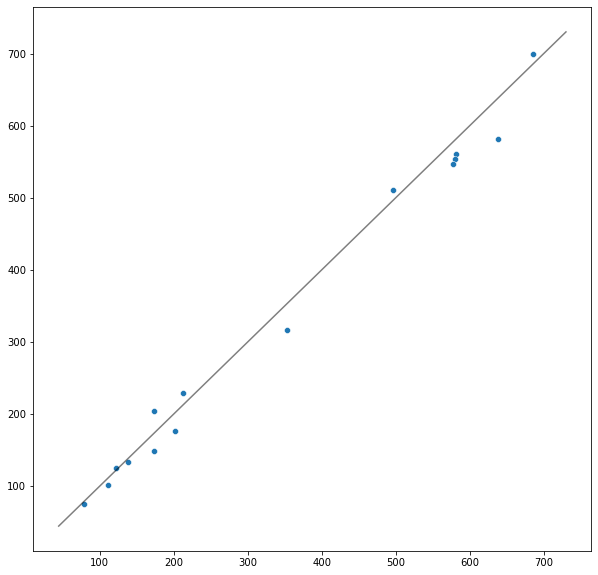

MSE:  645.5274965665287
MAE:  21.174488801620818
MAPE: 0.07212098585907344
R^2:  0.9862526369276337


In [12]:
train_report, test_report = get_reports("epping")
time = datetime.datetime(2022,3,8,11,14)
results, model = model_amdt(train_report, test_report, time)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.24it/s]


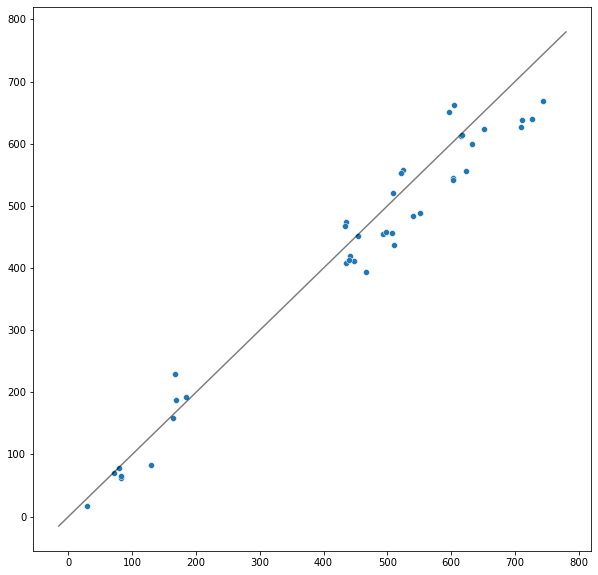

MSE:  2092.123010559938
MAE:  38.21560441037393
MAPE: 0.10457990276154741
R^2:  0.9517591357697569


In [13]:
train_report, test_report = get_reports("manchester")
time = datetime.datetime(2019,4,19,12,59)
results, model = model_amdt(train_report, test_report, time)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 10.05it/s]


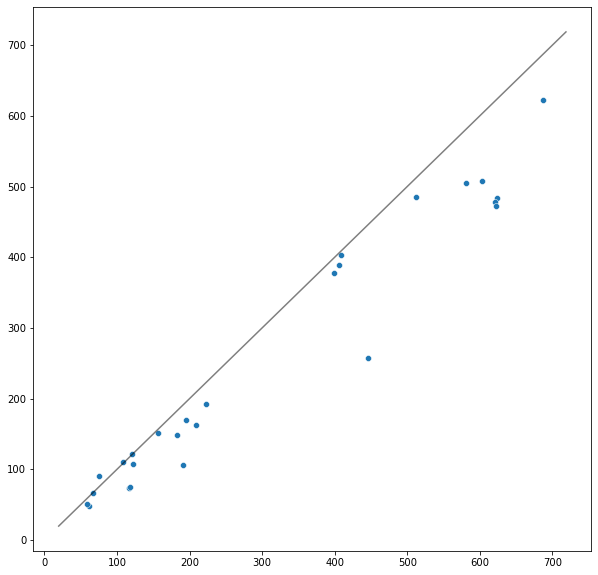

MSE:  5188.504114081371
MAE:  49.78648950205362
MAPE: 0.16415221325184529
R^2:  0.8865191545800708


In [14]:
train_report, test_report = get_reports("birmingham")
time = datetime.datetime(2021,6,15,11,14)
results, model = model_amdt(train_report, test_report, time)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.67it/s]


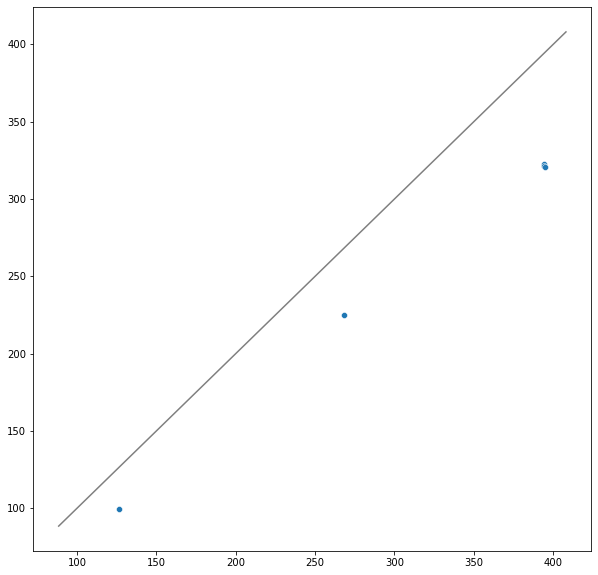

MSE:  3693.2093042361244
MAE:  57.635360806552704
MAPE: 0.18512673358673587
R^2:  0.6740979324027401


In [15]:
train_report, test_report = get_reports("bristol")
time = datetime.datetime(2021,6,15,11,14)
results, model = model_amdt(train_report, test_report, time)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 29.26it/s]


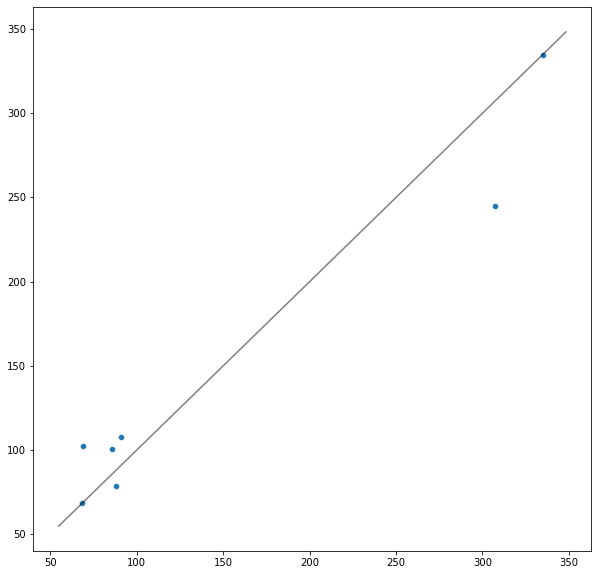

MSE:  791.9534628559769
MAE:  19.644922461898027
MAPE: 0.16639901694381684
R^2:  0.9337872892891178


In [16]:
train_report, test_report = get_reports("cambridge")
time = datetime.datetime(2021,6,15,11,14)
results, model = model_amdt(train_report, test_report, time)

### AADT with satalite images

In [ ]:
def model_aadt_segments(train_report, test_report, time, area):
    AADT_preds = []
    AADTs = []
    a = Normalised_Flow_Model(train_report)
    start_str, end_str = year_str(time)
    date_range = pd.date_range(start_str, end_str, freq="15min")
    traffic_predictions_focus = traffic_predictions[traffic_predictions.area == area]
    
    for sites_str in traffic_predictions_focus.sites:
        site_list = sites_str.split(',')
        test_report_site = test_report[(test_report.site_id.isin(site_list))]
        
        AADT = test_report_site[test_report_site.timestamp.isin(date_range)].total_volume.sum()/len(date_range)
        
        X_t = test_report_site[test_report_site.timestamp == time].total_volume.to_numpy()
        AADT_pred = X_t/a.N(time) * a.mean_N_year(time)
        # print(f"AADT {AADT}, X_t {X_t}, N(t) {a.N(time)}, N_(2021): {a.mean_N_year(2021)}, AADT_pred {AADT_pred}")
        AADTs.append(AADT)
        AADT_preds.append(AADT_pred.item())

    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=AADTs, y=AADT_preds, ax=ax)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    plt.plot(lims, lims, 'k-', alpha=0.5)

    plt.show()

    results = report_metrics(AADTs, AADT_preds)
    return results, a

In [60]:
image_year_report_birmingham = pd.read_feather('image_year_traffic_reports/clean_birmingham_report_df')

In [67]:
area = 'birmingham'
traffic_predictions_focus = traffic_predictions_focus = traffic_predictions[traffic_predictions.area == area]

In [71]:
for sites_str in traffic_predictions_focus.sites:
    site_list = sites_str.replace(' ', '').split(',')
    report_site = image_year_report_birmingham[(image_year_report_birmingham.site_id.isin(site_list))]    
    print({site for site in site_list} == {site for site in report_site.site_id.unique()})
    

True
True
True
True
True
True
True


In [72]:
report_site

,site_name,site_id,report_date,time_period_ending,time_interval,0-520cm,521-660cm,661-1160cm,1160+cm,avg_mph,total_volume,timestamp,0-520cm_normalised,521-660cm_normalised,661-1160cm_normalised,1160+cm_normalised,total_volume_normalised
489790,7642/2,9093,2021-01-01T00:00:00,00:14:00,0,13,0,0,1,49,14,2021-01-01 00:14:00,0.111286,0.000000,0.000000,0.127574,0.097478
489791,7642/2,9093,2021-01-01T00:00:00,00:29:00,1,18,0,0,0,54,18,2021-01-01 00:29:00,0.154088,0.000000,0.000000,0.000000,0.125329
489792,7642/2,9093,2021-01-01T00:00:00,00:44:00,2,12,1,0,0,53,13,2021-01-01 00:44:00,0.102725,0.104493,0.000000,0.000000,0.090515
489793,7642/2,9093,2021-01-01T00:00:00,00:59:00,3,10,0,0,0,50,10,2021-01-01 00:59:00,0.085604,0.000000,0.000000,0.000000,0.069627
489794,7642/2,9093,2021-01-01T00:00:00,01:14:00,4,12,0,1,0,49,13,2021-01-01 01:14:00,0.102725,0.000000,0.106418,0.000000,0.090515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520581,7642/2,9093,2021-12-31T00:00:00,22:59:00,91,38,0,0,0,52,38,2021-12-31 22:59:00,0.325296,0.000000,0.000000,0.000000,0.264583
520582,7642/2,9093,2021-12-31T00:00:00,23:14:00,92,34,1,0,0,53,35,2021-12-31 23:14:00,0.291054,0.104493,0.000000,0.000000,0.243695
520583,7642/2,9093,2021-12-31T00:00:00,23:29:00,93,31,1,0,1,53,33,2021-12-31 23:29:00,0.265373,0.104493,0.000000,0.127574,0.229770
520584,7642/2,9093,2021-12-31T00:00:00,23:44:00,94,26,0,1,0,52,27,2021-12-31 23:44:00,0.222571,0.000000,0.106418,0.000000,0.187993


In [74]:
train_report, test_report = get_reports("birmingham")
time = datetime.datetime(2021,6,15,11,14)

In [75]:
year_str(time)
start_str, end_str = year_str(time)
date_range = pd.date_range(start_str, end_str, freq="15min")

In [76]:
date_range

DatetimeIndex(['2021-01-01 00:14:00', '2021-01-01 00:29:00',
               '2021-01-01 00:44:00', '2021-01-01 00:59:00',
               '2021-01-01 01:14:00', '2021-01-01 01:29:00',
               '2021-01-01 01:44:00', '2021-01-01 01:59:00',
               '2021-01-01 02:14:00', '2021-01-01 02:29:00',
               ...
               '2021-12-31 21:44:00', '2021-12-31 21:59:00',
               '2021-12-31 22:14:00', '2021-12-31 22:29:00',
               '2021-12-31 22:44:00', '2021-12-31 22:59:00',
               '2021-12-31 23:14:00', '2021-12-31 23:29:00',
               '2021-12-31 23:44:00', '2021-12-31 23:59:00'],
              dtype='datetime64[ns]', length=35040, freq='15T')

In [79]:
len(report_site)/len(date_range)

0.8788812785388128

In [81]:
for sites_str in traffic_predictions_focus.sites:
    site_list = sites_str.replace(' ', '').split(',')
    for site in site_list:
        report_site = image_year_report_birmingham[(image_year_report_birmingham.site_id == site)]
        print(len(report_site)/len(date_range))
        

0.7558219178082192
0.9242294520547946
0.9378139269406393
0.861986301369863
0.9378710045662101
0.9906963470319635
0.7634417808219178
0.8788812785388128
0.8788812785388128
